In [67]:
%cd /content/drive/MyDrive/M.Tech CS_2022-23/Project/One Class Learning

/content/drive/MyDrive/M.Tech CS_2022-23/Project/One Class Learning


In [68]:
import numpy as np
import pandas as pd 
import random 
import os
from tqdm import tqdm
# from functools import partial
import matplotlib.pyplot as plt
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

pio.renderers.default = 'colab'

## 1. Import dataset

In [69]:
data_path = './data/CIFAR10/'

In [70]:
train_dataset = torchvision.datasets.CIFAR10(data_path, train=True)
test_dataset  = torchvision.datasets.CIFAR10(data_path, train=False)

def get_test_images(idx_list):
  return torch.stack([test_dataset[i][0] for i in idx_list], dim=0)

In [71]:
# fig, axs = plt.subplots(5, 5, figsize=(8,8))
# for ax in axs.flatten():
#     # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
#     img, label = random.choice(train_dataset)
#     ax.imshow(np.array(img), cmap='gist_gray')
#     ax.set_title(f'Label: {label}')
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.tight_layout()

In [72]:
# TPIL = transforms.ToPILImage()
TT = transforms.ToTensor()
NRM = transforms.Normalize(mean=(0.5,), std=(0.5,))

# train_transform = transforms.Compose([TPIL, TT, NRM])
train_transform = transforms.Compose([TT, NRM])
test_transform = transforms.Compose([TT, NRM])

# train_transform = transforms.Compose([TT])
# test_transform = transforms.Compose([TT])

In [73]:
def get_class_c(x, y, c):    
  y = np.array(y)    
  pos_c = np.argwhere(y == c)    
  pos_c = list(pos_c[:, 0])    
  class_c_data = [x[i] for i in pos_c]
  return class_c_data, [c]*len(pos_c)


class DatasetMaker(Dataset):
  def __init__(self, data, targets, transform_func=None):
    super().__init__()    
    self.data = data
    self.targets = targets
    self.transform_func = transform_func    

  def __getitem__(self, idx):
    img, target = self.data[idx], self.targets[idx]
    if self.transform_func:    
      img = self.transform_func(img)    
    return img, target

  def __len__(self):
    return len(self.targets)


def prepare_oc_dataset(dataset, class_label): 
  # get single class (class_label) data
  data, targets = get_class_c(dataset.data, dataset.targets, class_label)      
  return DatasetMaker(data, targets, train_transform)

In [74]:
true_label = 0

train_dataset = prepare_oc_dataset(train_dataset, true_label)
# train_dataset.transform = train_transform
test_dataset.transform = test_transform

# train_dataset = ConcatDataset([train_dataset, test_dataset])

In [75]:
len(train_dataset)

5000

In [76]:
#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)

train_data, val_data = random_split(train_dataset, [0.9, 0.1])

In [77]:
batch_size = 128

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## 2. Define Convolutional Autoencoder

In [78]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.ReLU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : number of channels in the output after the first convolution operation
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()        
        self.act_fn = act_fn
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 4*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(4*c_hid, 4*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(),
            # Image grid to single feature vector shape:[(4*c_hid)*(4*4)] 
            #  - number of channels has been increased 4 times
            #  - the final image size is 4x4
            nn.Linear((4*c_hid)*(4*4), latent_dim)            
        )
    
    def forward(self, x):
        return self.net(x)

In [79]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.ReLU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : number of channels in the input of the final transpose convolution operation
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        self.act_fn = act_fn
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, (4*c_hid)*(4*4)),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(4*c_hid, 4*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(4*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(2*c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
            # nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

## 3. Initialize Loss function and the optimizer

In [80]:
### Set the random seed for reproducible results
torch.manual_seed(3)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Initialize the two networks
num_input_channels, base_channel_size, latent_dim = 3, 32, 256

encoder = Encoder(num_input_channels, base_channel_size, latent_dim).to(device)
decoder = Decoder(num_input_channels, base_channel_size, latent_dim).to(device);

In [81]:
# ### Some examples
# # Take an input image (remember to add the batch dimension)
# img, _ = test_dataset[0]
# img = img.unsqueeze(0) # Add the batch dimension in the first axis
# print('Original image shape:', img.shape)
# # Encode the image

# img_enc = encoder(img)
# print('Encoded image shape:', img_enc.shape)

# # Decode the image
# dec_img = decoder(img_enc)
# #dec_img = model(img)
# print('Decoded image shape:', dec_img.shape)

In [82]:
### Define the loss function
loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()

lr= 0.001
params_to_optimize = [{'params': encoder.parameters()}, {'params': decoder.parameters()}]

optimizer = torch.optim.Adam(params_to_optimize, lr=lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=20, min_lr=5e-5)
# optim = torch.optim.Adam(params_to_optimize)

## 4. Train and evaluate model

In [83]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, optimizer):
  # Set train mode for both the encoder and the decoder
  encoder.train()
  decoder.train()    
  total_num, total_loss = 0, 0.

  # Iterate the dataloader (we do not need the label values, this is unsupervised learning)    
  for image_batch, _ in (train_bar := tqdm(dataloader)):
    image_batch = image_batch.to(device)

    # Encode data
    encoded_data = encoder(image_batch)
    # Decode data
    decoded_data = decoder(encoded_data)

    # Evaluate loss
    # loss = loss_fn(decoded_data, image_batch)
    # loss = loss_fn(decoded_data, image_batch[torch.randperm(image_batch.size()[0])])
    loss = F.mse_loss(image_batch, decoded_data, reduction="none")
    # loss = F.mse_loss(image_batch[torch.randperm(image_batch.size()[0])], decoded_data, reduction="none")
    loss = loss.sum(dim=[1,2,3]).mean(dim=[0])

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print batch loss      
    total_num += image_batch.shape[0]
    total_loss += loss.item() * image_batch.shape[0]
    train_bar.set_description(f'Train Epoch: [{epoch+1}/{num_epochs}] Loss: {total_loss / total_num :.4f}')
  
  return total_loss / total_num

In [84]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader):
  # Set evaluation mode for encoder and decoder
  encoder.eval()
  decoder.eval()
  total_num, total_loss = 0, 0.
  with torch.no_grad(): # No need to track the gradients      
    for image_batch, _ in (test_bar := tqdm(dataloader)):
      # Move tensor to the proper device
      image_batch = image_batch.to(device)

      # Encode data
      encoded_data = encoder(image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)

      loss = loss_fn(decoded_data, image_batch)
      # loss = F.mse_loss(image_batch, decoded_data, reduction="none")
      # loss = loss.sum(dim=[1,2,3]).mean(dim=[0])

      total_num += image_batch.shape[0]
      total_loss += loss.item() * image_batch.shape[0]
      test_bar.set_description(f'Test Epoch: [{epoch+1}/{num_epochs}] Loss: {total_loss / total_num :.4f}')

  return total_loss / total_num

In [85]:
def show_image(img):
  try:
    npimg = img.numpy()
  except AttributeError as ae:
    npimg = img
  npimg = (npimg - npimg.min()) / (npimg.max() - npimg.min())
  plt.imshow(np.transpose(npimg, (1, 2, 0)))


def plot_original_images(num_classes=10):
  plt.figure(figsize=(16, 4.5))  
  _targets = np.array(test_dataset.targets)
  t_idx = {}
  # gets the first samples of each of the `n` categories in the `test_dataset`;
  for i in range(num_classes):
    t_idx[i] = np.where(_targets == i)[0][0]
    ax = plt.subplot(2, num_classes, i+1)
    # `unsqueeze` to get the batch dimension
    # (Note that we're not using a dataloader to get these test images)
    img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
    show_image(img.cpu().squeeze())
    # plt.imshow(img.cpu().squeeze().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    # ax.set_title('Original images')
  plt.show()
  return t_idx


def plot_ae_outputs(encoder, decoder, t_idx, num_classes=10):
  plt.figure(figsize=(16, 4.5))
  encoder.eval()
  decoder.eval()    
  for i in range(num_classes):    
    ax = plt.subplot(2, num_classes, i+1+num_classes)
    with torch.no_grad():
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      rec_img  = decoder(encoder(img))
    show_image(rec_img.cpu().squeeze())
    # plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    # if i == n//2:
    #   ax.set_title('Reconstructed images')
  plt.show()

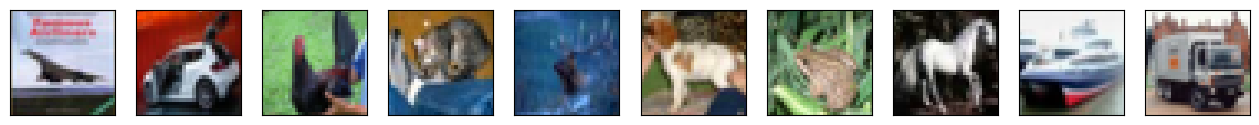

Train Epoch: [1/75] Loss: 645.1079: 100%|██████████| 36/36 [00:01<00:00, 28.75it/s]


Train Epoch: [2/75] Loss: 427.8228: 100%|██████████| 36/36 [00:01<00:00, 26.56it/s]


Train Epoch: [3/75] Loss: 307.6617: 100%|██████████| 36/36 [00:01<00:00, 25.77it/s]


Train Epoch: [4/75] Loss: 271.8306: 100%|██████████| 36/36 [00:01<00:00, 27.26it/s]


Train Epoch: [5/75] Loss: 250.6261: 100%|██████████| 36/36 [00:01<00:00, 34.40it/s]


Train Epoch: [6/75] Loss: 231.9310: 100%|██████████| 36/36 [00:01<00:00, 35.67it/s]


Train Epoch: [7/75] Loss: 219.7405: 100%|██████████| 36/36 [00:00<00:00, 36.19it/s]


Train Epoch: [8/75] Loss: 200.7481: 100%|██████████| 36/36 [00:01<00:00, 35.27it/s]


Train Epoch: [9/75] Loss: 180.7351: 100%|██████████| 36/36 [00:00<00:00, 36.24it/s]


Train Epoch: [10/75] Loss: 159.5596: 100%|██████████| 36/36 [00:01<00:00, 35.37it/s]


Train Epoch: [11/75] Loss: 149.1758: 100%|██████████| 36/36 [00:00<00:00, 36.13it/s]


Train Epoch: [12/75] Loss: 139.7485: 100%|██████████| 36/36 [00:00<00:00, 36.58it/s]


Train Epoch: [13/75] Loss: 131.8488: 100%|██████████| 36/36 [00:00<00:00, 36.73it/s]


Train Epoch: [14/75] Loss: 129.9620: 100%|██████████| 36/36 [00:01<00:00, 32.22it/s]


Train Epoch: [15/75] Loss: 123.0822: 100%|██████████| 36/36 [00:01<00:00, 30.03it/s]


Train Epoch: [16/75] Loss: 118.9934: 100%|██████████| 36/36 [00:01<00:00, 29.82it/s]


Train Epoch: [17/75] Loss: 115.4183: 100%|██████████| 36/36 [00:01<00:00, 28.25it/s]


Train Epoch: [18/75] Loss: 114.9008: 100%|██████████| 36/36 [00:01<00:00, 31.03it/s]


Train Epoch: [19/75] Loss: 108.6937: 100%|██████████| 36/36 [00:00<00:00, 36.25it/s]


Train Epoch: [20/75] Loss: 105.4927: 100%|██████████| 36/36 [00:00<00:00, 36.04it/s]


Train Epoch: [21/75] Loss: 104.0579: 100%|██████████| 36/36 [00:01<00:00, 35.89it/s]


Train Epoch: [22/75] Loss: 102.0470: 100%|██████████| 36/36 [00:00<00:00, 36.81it/s]


Train Epoch: [23/75] Loss: 100.8813: 100%|██████████| 36/36 [00:00<00:00, 36.22it/s]


Train Epoch: [24/75] Loss: 98.9991: 100%|██████████| 36/36 [00:00<00:00, 36.59it/s]


Train Epoch: [25/75] Loss: 97.2322: 100%|██████████| 36/36 [00:00<00:00, 36.46it/s]


Train Epoch: [26/75] Loss: 91.8403: 100%|██████████| 36/36 [00:01<00:00, 35.58it/s]


Train Epoch: [27/75] Loss: 89.6753: 100%|██████████| 36/36 [00:00<00:00, 36.31it/s]


Train Epoch: [28/75] Loss: 93.0497: 100%|██████████| 36/36 [00:01<00:00, 28.64it/s]


Train Epoch: [29/75] Loss: 87.3744: 100%|██████████| 36/36 [00:01<00:00, 27.97it/s]


Train Epoch: [30/75] Loss: 84.8925: 100%|██████████| 36/36 [00:01<00:00, 26.98it/s]


Train Epoch: [31/75] Loss: 83.5528: 100%|██████████| 36/36 [00:01<00:00, 30.61it/s]


Train Epoch: [32/75] Loss: 82.2880: 100%|██████████| 36/36 [00:01<00:00, 35.14it/s]


Train Epoch: [33/75] Loss: 82.3136: 100%|██████████| 36/36 [00:01<00:00, 35.98it/s]


Train Epoch: [34/75] Loss: 81.6242: 100%|██████████| 36/36 [00:01<00:00, 35.83it/s]


Train Epoch: [35/75] Loss: 77.5531: 100%|██████████| 36/36 [00:01<00:00, 35.84it/s]


Train Epoch: [36/75] Loss: 77.3649: 100%|██████████| 36/36 [00:01<00:00, 35.51it/s]


Train Epoch: [37/75] Loss: 75.6112: 100%|██████████| 36/36 [00:01<00:00, 35.31it/s]


Train Epoch: [38/75] Loss: 74.3671: 100%|██████████| 36/36 [00:00<00:00, 36.49it/s]


Train Epoch: [39/75] Loss: 74.6809: 100%|██████████| 36/36 [00:01<00:00, 35.97it/s]


Train Epoch: [40/75] Loss: 73.4425: 100%|██████████| 36/36 [00:01<00:00, 35.11it/s]


Train Epoch: [41/75] Loss: 73.1084: 100%|██████████| 36/36 [00:01<00:00, 28.48it/s]


Train Epoch: [42/75] Loss: 72.1047: 100%|██████████| 36/36 [00:01<00:00, 27.01it/s]


Train Epoch: [43/75] Loss: 69.1050: 100%|██████████| 36/36 [00:01<00:00, 25.97it/s]


Train Epoch: [44/75] Loss: 68.8301: 100%|██████████| 36/36 [00:01<00:00, 30.09it/s]


Train Epoch: [45/75] Loss: 67.3919: 100%|██████████| 36/36 [00:01<00:00, 33.07it/s]


Train Epoch: [46/75] Loss: 66.1600: 100%|██████████| 36/36 [00:01<00:00, 34.35it/s]


Train Epoch: [47/75] Loss: 65.0005: 100%|██████████| 36/36 [00:01<00:00, 35.37it/s]


Train Epoch: [48/75] Loss: 67.2021: 100%|██████████| 36/36 [00:01<00:00, 34.80it/s]


Train Epoch: [49/75] Loss: 64.2070: 100%|██████████| 36/36 [00:01<00:00, 35.56it/s]


Train Epoch: [50/75] Loss: 63.4705: 100%|██████████| 36/36 [00:01<00:00, 35.62it/s]


Train Epoch: [51/75] Loss: 67.6760: 100%|██████████| 36/36 [00:01<00:00, 35.07it/s]


Train Epoch: [52/75] Loss: 62.2699: 100%|██████████| 36/36 [00:01<00:00, 35.60it/s]


Train Epoch: [53/75] Loss: 61.0064: 100%|██████████| 36/36 [00:01<00:00, 34.42it/s]


Train Epoch: [54/75] Loss: 60.6814: 100%|██████████| 36/36 [00:01<00:00, 29.42it/s]


Train Epoch: [55/75] Loss: 61.0005: 100%|██████████| 36/36 [00:01<00:00, 27.46it/s]


Train Epoch: [56/75] Loss: 62.5661: 100%|██████████| 36/36 [00:01<00:00, 26.35it/s]


Train Epoch: [57/75] Loss: 60.0267: 100%|██████████| 36/36 [00:01<00:00, 29.48it/s]


Train Epoch: [58/75] Loss: 57.8833: 100%|██████████| 36/36 [00:01<00:00, 33.34it/s]


Train Epoch: [59/75] Loss: 58.4208: 100%|██████████| 36/36 [00:01<00:00, 34.55it/s]


Train Epoch: [60/75] Loss: 57.9758: 100%|██████████| 36/36 [00:01<00:00, 34.85it/s]


Train Epoch: [61/75] Loss: 57.9319: 100%|██████████| 36/36 [00:01<00:00, 34.80it/s]


Train Epoch: [62/75] Loss: 56.5538: 100%|██████████| 36/36 [00:01<00:00, 23.35it/s]


Train Epoch: [63/75] Loss: 55.6326: 100%|██████████| 36/36 [00:01<00:00, 22.95it/s]


Train Epoch: [64/75] Loss: 55.2378: 100%|██████████| 36/36 [00:01<00:00, 23.62it/s]


Train Epoch: [65/75] Loss: 56.7534: 100%|██████████| 36/36 [00:01<00:00, 29.11it/s]


Train Epoch: [66/75] Loss: 57.1647: 100%|██████████| 36/36 [00:01<00:00, 27.39it/s]


Train Epoch: [67/75] Loss: 54.4199: 100%|██████████| 36/36 [00:01<00:00, 26.78it/s]


Train Epoch: [68/75] Loss: 53.7513: 100%|██████████| 36/36 [00:01<00:00, 27.52it/s]


Train Epoch: [69/75] Loss: 54.4210: 100%|██████████| 36/36 [00:01<00:00, 34.61it/s]


Train Epoch: [70/75] Loss: 59.9665: 100%|██████████| 36/36 [00:01<00:00, 34.47it/s]


Train Epoch: [71/75] Loss: 53.4924: 100%|██████████| 36/36 [00:01<00:00, 34.67it/s]


Train Epoch: [72/75] Loss: 51.7440: 100%|██████████| 36/36 [00:01<00:00, 35.69it/s]


Train Epoch: [73/75] Loss: 51.5836: 100%|██████████| 36/36 [00:01<00:00, 35.72it/s]


Train Epoch: [74/75] Loss: 51.5862: 100%|██████████| 36/36 [00:01<00:00, 34.95it/s]


Train Epoch: [75/75] Loss: 51.6135: 100%|██████████| 36/36 [00:00<00:00, 36.07it/s]


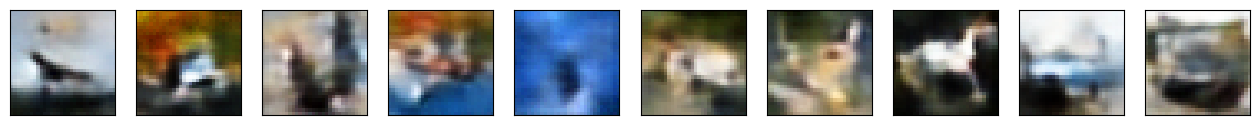

In [86]:
num_epochs = 75
history = {'train_loss':[],'val_loss':[]}

t_idx = plot_original_images()

for epoch in range(num_epochs):  
  train_loss = train_epoch(encoder, decoder, device, train_loader, optimizer)  
  # val_loss = test_epoch(encoder, decoder, device, val_loader)
  print()
  history['train_loss'].append(train_loss)
  # history['val_loss'].append(val_loss)
  # if epoch+1 % 10 == 0:
  # plot_ae_outputs(encoder, decoder, t_idx)
  # lr_scheduler.step(val_loss)

plot_ae_outputs(encoder, decoder, t_idx)

In [87]:
# test_epoch(encoder, decoder, device, test_loader, loss_fn).item()

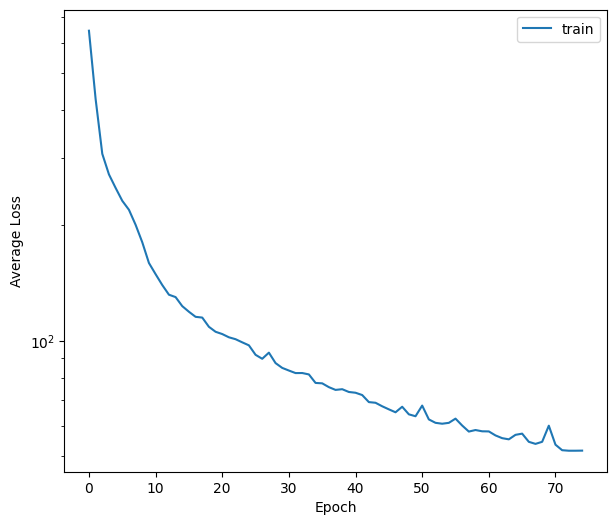

In [88]:
# Plot losses
plt.figure(figsize=(7, 6))
plt.semilogy(history['train_loss'], label='train')
# plt.semilogy(history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [98]:
del history['val_loss']

In [99]:
data_frame = pd.DataFrame(data=history, index=range(1, num_epochs + 1))
data_frame.to_csv(f'results/{num_epochs}_epochs_{latent_dim}_vanilla_AE_0.csv', index_label='epoch')

In [89]:
torch.save(encoder.state_dict(), f'pre-trained models/CIFAR10/{latent_dim}_vanilla_enc_0.pt')
torch.save(decoder.state_dict(), f'pre-trained models/CIFAR10/{latent_dim}_vanilla_dec_0.pt');

In [90]:
# encoder = Encoder(num_input_channels, base_channel_size, latent_dim)
# decoder = Decoder(num_input_channels, base_channel_size, latent_dim)

# encoder.load_state_dict(torch.load(f'pre-trained models/CIFAR10/{latent_dim}_vanilla_enc.pt'))
# encoder = encoder.to(device);

# decoder.load_state_dict(torch.load(f'pre-trained models/CIFAR10/{latent_dim}_vanilla_dec.pt'))
# decoder = decoder.to(device);

# vanilla_decoder.load_state_dict(torch.load(f'pre-trained models/{latent_dim}_vanilla_dec.pt'));
# vanilla_decoder.to(device);

In [91]:
def get_test_images(idx_list):
  return torch.stack([test_dataset[i][0] for i in idx_list], dim=0)


def visualize_reconstructions(input_imgs):
  # model = nn.Sequential(encoder, decoder)
  # Reconstruct images
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
      reconst_imgs = decoder(encoder(input_imgs.to(device)))
  reconst_imgs = reconst_imgs.cpu()
  
  # Plotting
  imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
  grid = torchvision.utils.make_grid(imgs, nrow=10, normalize=True, scale_each=True)
  grid = grid.permute(1, 2, 0)
  plt.figure(figsize=(8, 9))
  plt.title(f"Reconstructed from {latent_dim} latents")
  plt.imshow(grid)
  plt.axis('off')
  plt.show()

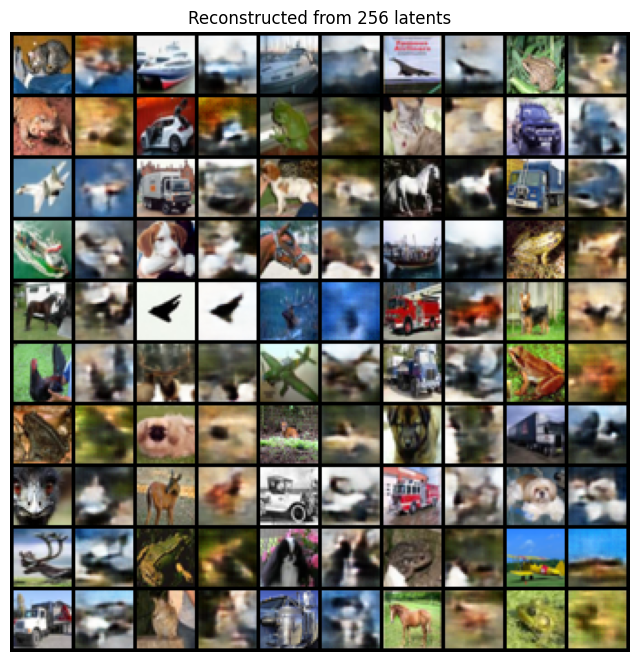

In [92]:
# num_examples = 8
# test_img_idx_list = [random.choice(range(len(test_dataset))) for _ in range(num_examples)]
test_img_idx_list = list(range(50))

test_imgs = get_test_images(test_img_idx_list)
visualize_reconstructions(test_imgs)

## Feature visualizations

###Utility functions

In [93]:
def preprocess_image(img):
  img.unsqueeze_(0)
  img.requires_grad = True
  return img

###Guided Backprop

In [94]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activation_maps = []
        # Put model in evaluation mode
        self.model.eval()
        self.register_hooks()
    
    
    def register_hooks(self):
        def first_layer_hook_fn(module, grad_in, grad_out):
            self.gradients = grad_in[0] 

        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            grad = self.activation_maps.pop()
            # for the forward pass, after the ReLU operation, 
            # if the output value is positive, we set the value to 1,
            # and if the output value is negative, we set it to 0.
            grad[grad > 0] = 1 
            
            # grad_out[0] stores the gradients for each feature map,
            # and we only retain the positive gradients
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            new_grad_in = positive_grad_out * grad

            return (new_grad_in,)
        
        self.modules = list(next(self.model.children()).children())

        # travese the modules，register forward hook & backward hook
        # for the activation function
        for module in self.modules:
            if isinstance(module, self.model.act_fn):
                module.register_forward_hook(forward_hook_fn)
                module.register_full_backward_hook(backward_hook_fn)

        # register backward hook for the first conv layer
        first_layer = self.modules[0]
        first_layer.register_full_backward_hook(first_layer_hook_fn)

    
    def generate_gradients(self, input_image, target_class):        
        input_image = input_image.to(device)
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()        
        model_output.backward(gradient=torch.ones_like(model_output))        
        gradients_as_arr = self.gradients.cpu().data
        return gradients_as_arr

###Visualize on a few Test images

In [95]:
num_examples = 8
guided_grads = []
pretrained_model = encoder

# Guided backprop
GBP = GuidedBackprop(pretrained_model)

# test_img_idx_list = [random.choice(range(len(test_dataset))) for _ in range(num_examples)]
test_img_idx_list = list(range(50))

for i, eg in enumerate(test_img_idx_list):  
  img, target = test_dataset[eg]
  img = preprocess_image(img)
  guided_grads.append(GBP.generate_gradients(img, target))

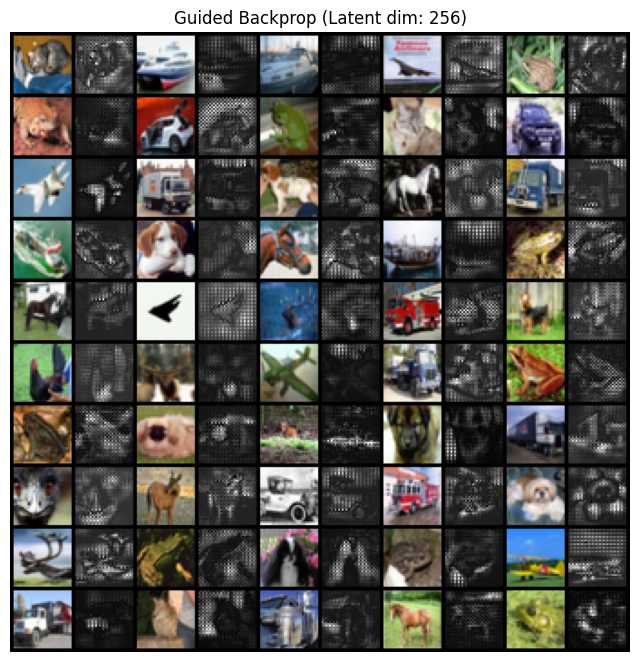

In [96]:
test_imgs = get_test_images(test_img_idx_list)
display_grads = torch.cat(guided_grads, dim=0)
grad_times_img = transforms.Grayscale()(test_imgs * display_grads).expand_as(test_imgs)

# Plotting
# imgs = torch.stack([test_imgs, display_grads], dim=1).flatten(0,1)
imgs = torch.stack([test_imgs, grad_times_img], dim=1).flatten(0,1)
grid = torchvision.utils.make_grid(imgs, nrow=10, normalize=True, scale_each=True)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8, 9))
plt.title(f"Guided Backprop (Latent dim: {latent_dim})")
plt.imshow(grid)
plt.axis('off')
plt.show()

## 5. Generate new samples from the latent code

In [ ]:
encoder.eval()
decoder.eval()

with torch.no_grad():
  # calculate mean and std of latent code generated taking in test images as inputs 
  images, labels = next(iter(test_loader))
  images = images.to(device)
  latent = encoder(images)
  latent = latent.cpu()

  mean = latent.mean(dim=0)  
  # print(mean)
  std = (latent - mean).pow(2).mean(dim=0).sqrt()  
  # print(std)

  # sample 100 latent vectors from the normal distribution
  latent = torch.randn(100, latent_dim)*std + mean

  # reconstruct images from the random latent vectors
  latent = latent.to(device)
  img_recon = decoder(latent)
  img_recon = img_recon.cpu()  

  fig, ax = plt.subplots(figsize=(20, 15))
  show_image(torchvision.utils.make_grid(img_recon, 10, 2))  
  plt.show()

In [ ]:
# train_mean_encoding.shape

In [ ]:
# mean_class_image = decoder(mean.unsqueeze(0).to(device)).squeeze().detach().cpu()

In [ ]:
# mean_class_image.shape

In [ ]:
# plt.imshow(mean_class_image.numpy(), cmap='gist_gray')
# plt.axis('off')
# plt.show()

## 6. Visualize Latent Code 

In [ ]:
def get_encodings(dataset):
  encoder.eval()
  decoder.eval()
  encoded_samples = []
  for sample in tqdm(dataset):
      img = sample[0].unsqueeze(0).to(device)      
      label = sample[1]
      # Encode image      
      with torch.no_grad():
          encoded_img = encoder(img)
          decoded_img = decoder(encoded_img)
      # Append to list
      encoded_img = encoded_img.flatten().cpu().numpy()
      decoded_img = decoded_img.cpu()
      encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
      encoded_sample['label'] = label                  
      encoded_samples.append(encoded_sample)

  return encoded_samples

In [ ]:
encoded_samples = get_encodings(test_dataset)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples
# test_samples = get_samples_encodings(test_loader, true_label)

In [ ]:
# px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
# def get_samples_encodings(dataloader, true_label):
#   encoder.eval()  
#   encoded_samples, labels = [], []
#   for batch in tqdm(dataloader):
#       img_batch = batch[0].to(device)      
#       label_batch = batch[1]
#       # Encode image      
#       with torch.no_grad():
#           encoded_imgs = encoder(img_batch)
#       # Append to list
#       encoded_imgs = encoded_imgs.detach().squeeze().cpu()
#       encoded_samples.append(encoded_imgs)
#       labels.append(label_batch)

#   samples = torch.cat([torch.cat(encoded_samples), torch.cat(labels).unsqueeze(1)], dim=1)
#   return samples

In [ ]:
# train_samples = get_samples_encodings(train_loader, true_label)
# torch.save(train_samples, './data/MNIST/Autoencoder - shuffled/train_data.data')

# test_samples = get_samples_encodings(test_loader, true_label)
# torch.save(test_samples, './data/MNIST/Autoencoder - shuffled/test_data.data')

# train_samples = pd.DataFrame(train_samples)
# test_samples = pd.DataFrame(test_samples)

In [ ]:
# similarity_measure = SiameseNetwork().to(device)
# siamese_network = torch.load('./pre-trained models/siamese_network.pt')
# similarity_measure.load_state_dict(siamese_network)
# similarity_measure.eval();

In [ ]:
# def similarities(dataloader):
#   # encoder.eval()
#   # decoder.eval()
#   similarities = []
#   labels = []  
#   for batch in tqdm(dataloader):
#     img_batch = batch[0].to(device)
#     label_batch = batch[1]
#     with torch.no_grad():
#         encoded_imgs = encoder(img_batch)
#         decoded_imgs = decoder(encoded_imgs)
#     similarities.append(similarity_measure(img_batch, decoded_imgs).squeeze().cpu())
#     # similarities.append(similarity_measure(img_batch, mean_class_image.expand_as(img_batch)).squeeze().cpu())            
#     labels.append(label_batch.squeeze())

#   similarities, labels = torch.cat(similarities), torch.cat(labels)
#   return similarities, labels

In [ ]:
# test_similarities, test_labels = similarities(test_loader)

In [ ]:
# def errors(dataloader):
#   distances, labels = [], []
#   encoder.eval()
#   decoder.eval()
#   error_metric = torch.nn.L1Loss(reduction='none')
#   # error_metric = torch.nn.MSELoss(reduction='none')
#   # vanilla_encoder.eval()
#   # vanilla_decoder.eval()

#   for img_batch, label_batch in tqdm(dataloader):
#     img_batch = img_batch.to(device)
#     with torch.no_grad():
#       # vanilla_encoded_imgs = vanilla_encoder(img_batch)
#       # vanilla_decoded_imgs = decoder(vanilla_encoded_imgs).reshape(img_batch.shape[0], -1)
#       encoded_imgs = encoder(img_batch)
#       decoded_imgs = decoder(encoded_imgs)
#     # distances.append(torch.sum((encoded_imgs - vanilla_encoded_imgs) ** 2, dim=1).detach().cpu())
#     distances.append(error_metric(decoded_imgs.reshape(img_batch.shape[0], -1),
#                                   img_batch.reshape(img_batch.shape[0], -1)
#                                   ).detach().cpu())    
#     labels.append(label_batch.squeeze())

#   distances, labels = torch.cat(distances).mean(dim=1), torch.cat(labels)
#   # distances, labels = torch.cat(distances).sum(dim=1), torch.cat(labels)
#   return distances, labels

In [ ]:
# test_errors, test_labels = errors(test_loader)

In [ ]:
# # test_stats_tensor = torch.stack([test_similarities, test_labels], dim=1)
# test_stats_tensor = torch.stack([test_errors, test_labels], dim=1)
# test_stats_tensor.size()

In [ ]:
# # test_stats = pd.DataFrame(test_stats_tensor.data.numpy(), columns=['similarity', 'label'])
# test_stats = pd.DataFrame(test_stats_tensor.data.numpy(), columns=['loss', 'label'])
# test_stats

In [ ]:
# px.scatter(test_stats, x=test_stats['loss'], y=test_stats.index, color=test_stats.label.astype(str), opacity=0.7)
# px.scatter(test_stats, x=test_stats['similarity'], y=test_stats.index, color=test_stats.label.astype(str), opacity=0.7)

In [ ]:
# plt.figure(figsize=(17, 9))
# plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'], c=encoded_samples.label, cmap='tab10')
# plt.colorbar()
# plt.show()

In [ ]:
# plt.figure(figsize=(17, 9))
# plt.scatter(list(range(len(encoded_samples))), encoded_samples['Loss'], c=encoded_samples.label, cmap='tab10')
# plt.colorbar()
# plt.show()

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(encoded_samples.drop(['label'],axis=1))
total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)

In [ ]:
fig = px.scatter(components, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

In [ ]:
# plt.figure(figsize=(17, 9))
# plt.scatter(components[:,0], components[:,1], c=encoded_samples.label, cmap='tab10')
# plt.colorbar()
# plt.show()

In [ ]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [ ]:
# fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
# fig.show()

In [ ]:
# plt.figure(figsize=(17, 9))
# plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10')
# plt.colorbar()
# plt.show()

##Notes

* Train without bias
* Compare augmented images without perceptual loss.